# Understanding difference between Lasso, Ridge and Elastic Net regression. 

__Regularization__, which is a form of regression, constrains/ regularizes or shrinks the coefficient estimates towards zero. The main aim of regularization is to reduce the model complexity and reduce overfitting that may result from LinearRegression. There are many types of Regularization techniques, however Rigde and Lasso (L2 and L1 respectively) regresssion are the two most commonly used.

In __Ridge__ (L2) regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients. Whereas in __Lasso__ (L1) regression, the penalty is just the magnitude of coefficients. If that was not enough, we even have a third kind of regularization known as __Elastic Net__ Regression which combines Lasso and Ridge regression to get the best of both worlds.

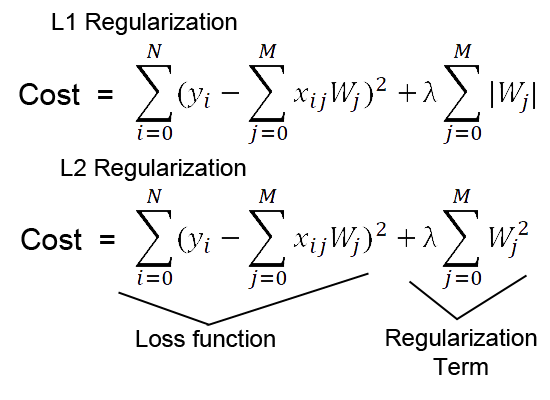

In this small demonstration, we would try to understand the difference between the 3 types of regularizations discussed above. 

In [4]:
library(glmnet)

Loading required package: Matrix

Loaded glmnet 4.1-1



# Example 1

4985 useless variables in the model, only 15 that are useful.

Also, not much data relative to the number of parameters.

1,000 samples and 5,000 parameters.

In [5]:
set.seed(42)  # Set seed for reproducibility

n <- 1000  # Number of observations
p <- 5000  # Number of predictors included in model
real_p <- 15  # Number of true predictors

## Generate the data
x <- matrix(rnorm(n*p), nrow=n, ncol=p)
y <- apply(x[,1:real_p], 1, sum) + rnorm(n) # Creates a vector y that is dependant on the first 15 columns in x. 

In [6]:
## Split data into training and testing datasets.
## 2/3rds of the data will be used for Training and 1/3 of the
## data will be used for Testing.
train_rows <- sample(1:n, .66*n)
x.train <- x[train_rows, ]
x.test <- x[-train_rows, ]

y.train <- y[train_rows]
y.test <- y[-train_rows]

We would now apply Ridge, lasso and Elastic Net regression on the datasets created above using the `glmnet` function which implements various regularisers (e.g. $\ell_1$, $\ell_2$, and a combination of the two which is called the "elastic net"). 

## Ridge Regression

For the inital step of `Ridge regression`, we would use the `cv.glmnet` function to fit a model to the training data to use cross validation to obtain optimal values for the `lambda`. By default, the `cv.glmnet` function uses 10 fold cross validation. 

In [9]:
alpha0.fit <- cv.glmnet(x.train, y.train, # unlike glm we cannot use `~` here
                        type.measure="mse", #mean squared error
                        alpha=0, # for ridge regression
                        family="gaussian") # for linear regression (for logistic set to `binomial`)

Now let's run the Testing dataset on the model created for alpha = 0 (i.e. Ridge Regression).

In [10]:
alpha0.predicted <- 
  predict(alpha0.fit, 
          s=alpha0.fit$lambda.1se, # correspond to lambda i.e. size of the penalty. 
          newx=x.test # testing dataset)

Here, `lambda.1se` is the value for lambda that results in the simplest model such that the cross validation error is within one standard error of the minimum.If we wanted to to specify the lambda that results in the
model with the minimum cross valdiation error, not a model within one SE of of the minimum, we would 
set 's' to `lambda.min`. To keep things consistant when we compare different alphas, it makes sense to use `lambda.1se` all the time.

Now, let's calculate the Mean Squared Error (MSE) for the model created for alpha = 0.

In [11]:
mean((y.test - alpha0.predicted)^2)

[1] 14.88459

## Lasso Regression

We perform steps similar to above, only here we set the alpha value to 1 for `Lasso Regression`.

In [12]:
alpha1.fit <- cv.glmnet(x.train, y.train, type.measure="mse", 
  alpha=1, family="gaussian")

alpha1.predicted <- 
  predict(alpha1.fit, s=alpha1.fit$lambda.1se, newx=x.test)

mean((y.test - alpha1.predicted)^2)

[1] 1.184701

We can see how we were able to significantly drop the mean squared error when introducing `Lasso regression`. 

## Elastic-Net Regression

Finally, to perform the `Elastic-Net regression`, we set `alpha = 0.5`, a 50/50 mixture of Ridge and Lasso Regression. 

In [13]:
alpha0.5.fit <- cv.glmnet(x.train, y.train, type.measure="mse", 
  alpha=0.5, family="gaussian")

alpha0.5.predicted <- 
  predict(alpha0.5.fit, s=alpha0.5.fit$lambda.1se, newx=x.test)

mean((y.test - alpha0.5.predicted)^2)

[1] 1.23797

Not bad at all! So, we can clearly see how in this use case, it's best if we use either Lasso or Elastic-Net regression to ensure minimum error. However, rather than deciding on the value of alpha on our own, we can use `cross-validation` to find optimal value of `lambda` for different values of `alpha` (alpha = 0, 0.1, 0.2 .... ,1.0)

## Performing Cross validation for alpha

In [14]:
list.of.fits <- list()
for (i in 0:10) {

  fit.name <- paste0("alpha", i/10)
  
    list.of.fits[[fit.name]] <-
    cv.glmnet(x.train, y.train, type.measure="mse", alpha=i/10, 
      family="gaussian")
}

Now we see which alpha (0, 0.1, ... , 0.9, 1) does the best job predicting the values in the Testing dataset.

In [15]:
results <- data.frame()
for (i in 0:10) {
  fit.name <- paste0("alpha", i/10)
  
  ## Use each model to predict 'y' given the Testing dataset
  predicted <- 
    predict(list.of.fits[[fit.name]], 
      s=list.of.fits[[fit.name]]$lambda.1se, newx=x.test)
  
  ## Calculate the Mean Squared Error...
  mse <- mean((y.test - predicted)^2)
  
  ## Store the results
  temp <- data.frame(alpha=i/10, mse=mse, fit.name=fit.name)
  results <- rbind(results, temp)
}

## View the results
results

alpha,mse,fit.name
<dbl>,<dbl>,<chr>
0.0,14.918840,alpha0
0.1,2.256924,alpha0.1
0.2,1.472927,alpha0.2
0.3,1.362394,alpha0.3
0.4,1.259794,alpha0.4
0.5,1.252103,alpha0.5
0.6,1.253330,alpha0.6
0.7,1.212927,alpha0.7
0.8,1.184028,alpha0.8


# Example 2 

3500 useless variables, 1500 useful (so lots of useful variables)

1,000 samples and 5,000 parameters

## Preparing data

Similar to the Example 1, we prepare our training and testing data, only in this case we have relatively more number of useful variables!

In [16]:
set.seed(42) # Set seed for reproducibility

n <- 1000    # Number of observations
p <- 5000     # Number of predictors included in model
real_p <- 1500  # Number of true predictors

## Generate the data
x <- matrix(rnorm(n*p), nrow=n, ncol=p)
y <- apply(x[,1:real_p], 1, sum) + rnorm(n)

# Split data into train (2/3) and test (1/3) sets
train_rows <- sample(1:n, .66*n)
x.train <- x[train_rows, ]
x.test <- x[-train_rows, ]

y.train <- y[train_rows]
y.test <- y[-train_rows]

## Using Cross-validation to find the best fit. 

In [17]:
list.of.fits <- list()
for (i in 0:10) {
  fit.name <- paste0("alpha", i/10)
  
  list.of.fits[[fit.name]] <-
    cv.glmnet(x.train, y.train, type.measure="mse", alpha=i/10, 
      family="gaussian")
}

results <- data.frame()
for (i in 0:10) {
  fit.name <- paste0("alpha", i/10)
  
  predicted <- 
    predict(list.of.fits[[fit.name]], 
      s=list.of.fits[[fit.name]]$lambda.1se, newx=x.test)
  
  mse <- mean((y.test - predicted)^2)
  
  temp <- data.frame(alpha=i/10, mse=mse, fit.name=fit.name)
  results <- rbind(results, temp)
}

results

alpha,mse,fit.name
<dbl>,<dbl>,<chr>
0.0,1400.375,alpha0
0.1,1545.035,alpha0.1
0.2,1545.035,alpha0.2
0.3,1545.035,alpha0.3
0.4,1545.035,alpha0.4
0.5,1545.035,alpha0.5
0.6,1545.035,alpha0.6
0.7,1545.035,alpha0.7
0.8,1545.035,alpha0.8


From the results generated above, we can see the value of `alpha = 0` gives us the least MSE. Since in this case we had a lot more useful variables, this use case shows when `Ridge regression` would be the preferred choice of regularization. 

# Summary 

While choosing which regularization to use, we need to keep in mind that Elastic Net regression works better when we have correlated parameters, Ridge regression works best when most of the variables in our model are useful and Lasso regression is used when we are aware about the presence of un-important features in our data. Happy learning!